In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
from linear_reassignment import high_resolution_spectogram as high_resolution_spectogram_numpy
from linear_reassignment import high_resolution_spectogram_sparse as high_resolution_spectogram_numpy_sparse
from linear_reassignment_pytorch import high_resolution_spectogram, high_resolution_spectogram_float32
from scipy.io import wavfile
import librosa
from scipy.io import loadmat

In [2]:
result_matlab = loadmat('data/verify_correctness.mat')['result']
x_matlab = loadmat('data/verify_correctness.mat')['x']

Plotting the result from Matlab.

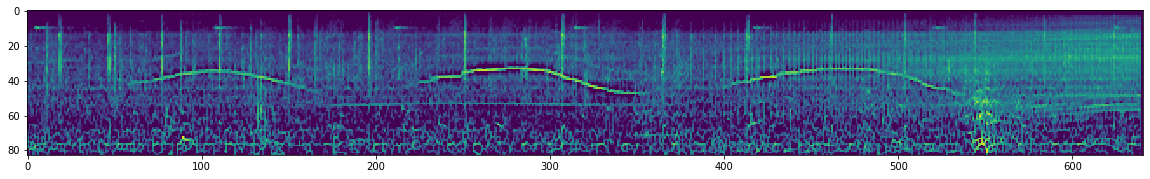

In [3]:
plt.figure(figsize = (20,4))
plt.imshow(librosa.core.amplitude_to_db(result_matlab.todense().T))

In [4]:
q = 2;
tdeci = 450;
over = 20;
noct = 12;
minf = 4e-3;
maxf = 0.45;

Let us first run the calculations on the GPU using Pytorch.

In [5]:
%%time

result_pytorch = high_resolution_spectogram(x_matlab, q, tdeci, over, noct, minf, maxf, 'cuda')

CPU times: user 12.6 s, sys: 3.33 s, total: 15.9 s
Wall time: 16.5 s


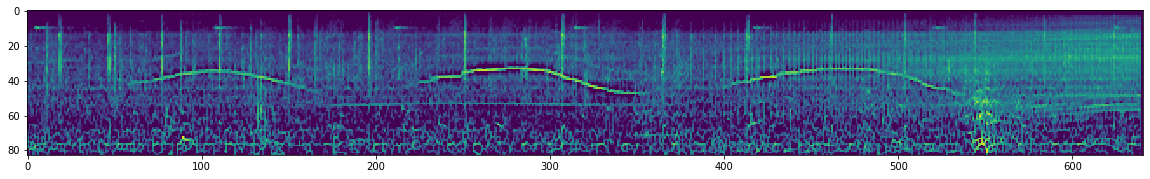

In [6]:
plt.figure(figsize = (20,4))
plt.imshow(librosa.core.amplitude_to_db(result_pytorch.cpu().numpy().T))

`high_resolution_spectogram_float32` is 2x faster than `high_resolution_spectogram` (which uses `float64`) but is only accurate to 1e-4 to what is returned by the original Matlab code.

In [7]:
%%time

result_pytorch_float32 = high_resolution_spectogram_float32(x_matlab, q, tdeci, over, noct, minf, maxf, 'cuda')

CPU times: user 6.61 s, sys: 1.06 s, total: 7.67 s
Wall time: 6.7 s


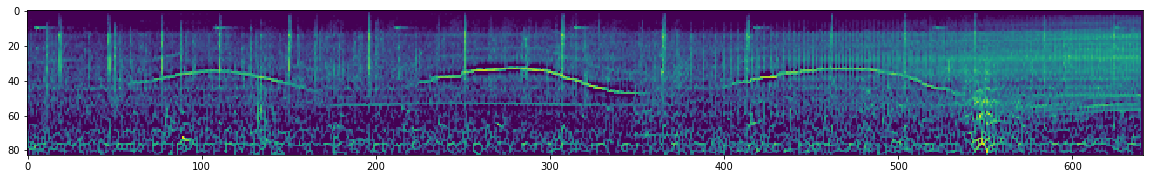

In [8]:
plt.figure(figsize = (20,4))
plt.imshow(librosa.core.amplitude_to_db(result_pytorch_float32.cpu().numpy().T))

Numpy running on the CPU is much, much slower. Still, it is ~20% faster than Pytorch code executed on the CPU.

Both the numpy code below and Pytorch implementation using `DoubleTensors` return exactly the same results at the Matlab code.

In [9]:
%%time

result_python_dense = high_resolution_spectogram_numpy(x_matlab, q, tdeci, over, noct, minf, maxf)

CPU times: user 33min 24s, sys: 1min 22s, total: 34min 47s
Wall time: 5min 48s


The sparse implementation is much slower. Part of the slow down is due to the fact that I had to resolve to using swap. Nonetheless, even on simpler spectograms, this implementation will be at least 2x slower than the one above.

The sparse implementation mimics most closely the Matlab implementation. It's memory footprint will grow (it's maximum size can be controlled by the `MAXL` parameter hard coded in the function body).

In [10]:
%%time

result_python_sparse = high_resolution_spectogram_numpy_sparse(x_matlab, q, tdeci, over, noct, minf, maxf)

CPU times: user 1h 24min 44s, sys: 1h 5min 54s, total: 2h 30min 38s
Wall time: 26min 55s


In [11]:
result_matlab.todense()[0, :10]

matrix([[7.84406079e-06, 2.43280844e-05, 2.38775212e-05, 3.25661946e-05,
         3.97327638e-05, 4.30144901e-05, 5.24843663e-05, 5.37024620e-05,
         5.86939640e-05, 9.62354563e-05]])

In [12]:
result_python_dense[0, :10]

array([7.84406079e-06, 2.43280844e-05, 2.38775212e-05, 3.25661946e-05,
       3.97327638e-05, 4.30144901e-05, 5.24843663e-05, 5.37024620e-05,
       5.86939640e-05, 9.62354563e-05])

In [13]:
result_python_sparse.todense()[0, :10]

matrix([[7.84406079e-06, 2.43280844e-05, 2.38775212e-05, 3.25661946e-05,
         3.97327638e-05, 4.30144901e-05, 5.24843663e-05, 5.37024620e-05,
         5.86939640e-05, 9.62354563e-05]])

In [14]:
result_pytorch[0, :10]

tensor([7.8441e-06, 2.4328e-05, 2.3878e-05, 3.2566e-05, 3.9733e-05, 4.3014e-05,
        5.2484e-05, 5.3702e-05, 5.8694e-05, 9.6235e-05], device='cuda:0',
       dtype=torch.float64)

In [15]:
result_pytorch_float32[0, :10]

tensor([7.8441e-06, 2.4328e-05, 2.3877e-05, 3.2566e-05, 3.9733e-05, 4.3015e-05,
        5.2484e-05, 5.3703e-05, 5.8694e-05, 9.6236e-05], device='cuda:0')

In [16]:
np.max(result_matlab.todense() - result_python_dense)

1.199040866595169e-14

In [17]:
np.max(result_matlab.todense() - result_python_sparse.todense())

8.881784197001252e-15

In [18]:
np.max(result_matlab.todense() - result_pytorch.cpu().numpy())

1.2656542480726785e-14

In [19]:
np.max(result_matlab.todense() - result_pytorch_float32.cpu().numpy())

9.047337450041049e-05

In [20]:
np.allclose(result_matlab.todense(), result_python_dense, atol=1e-100)

True

In [21]:
np.allclose(result_matlab.todense(), result_python_sparse.todense(), atol=1e-100)

True

In [22]:
np.allclose(result_matlab.todense(), result_pytorch.cpu().numpy(), atol=1e-100)

True

In [23]:
np.allclose(result_matlab.todense(), result_pytorch_float32.cpu().numpy(), atol=1e-4)

True